In [1]:
# Solo se necesita ejecutar una vez
# Todos los archivos quedan guardados en /kaggle/working de manera permanente
!git clone https://github.com/zyainfal/One-Shot-Face-Swapping-on-Megapixels.git /kaggle/tmp/One-Shot-Face-Swapping-on-Megapixels
!pip install gdown #libreria para descargar directamente desde Drive
!gdown https://drive.google.com/drive/folders/1XDakvzNHDtC7G1d1Zn8MjPbmen4LKLPw -O /kaggle/tmp/One-Shot-Face-Swapping-on-Megapixels/inference/checkpoint --folder 
#contiene los pesos del encoder
!git clone https://github.com/rosinality/stylegan2-pytorch /kaggle/tmp/stylegan2-pytorch
!mv /kaggle/tmp/stylegan2-pytorch/op /kaggle/tmp/One-Shot-Face-Swapping-on-Megapixels/inference/ #Repositorio de la Gan que estamos usando como decodificador 

Cloning into '/kaggle/tmp/One-Shot-Face-Swapping-on-Megapixels'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 316 (delta 13), reused 13 (delta 11), pack-reused 299
Receiving objects: 100% (316/316), 11.42 MiB | 25.54 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Retrieving folder contents
Processing file 1sBAQe1Eama6IM9H2MEmoPbSX2_l1FwH5 ftm_final.pth
Processing file 1lOj5vSNKGjnWvvkYAE2V12l0-HiA0rY1 injection_final.pth
Processing file 1BiCSTz1uLXSdN-ekM5xu-k6jzLv9VmPV lcr_final.pth
Processing file 1lfAFXvBRbJ3uNfuNOdlew3BiAqtury4D stylegan2-ffhq-config-f.pth
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1sBAQe1Eama6IM9H2MEmoPbSX2_l1FwH5
From (redirected): https://drive.google.com/uc?id=1sBAQe1Eama6IM9H2MEmoPbSX2_l1FwH5&confirm=t&uuid=affbd9d5-896b-4f10-b1b

In [2]:
%cd /kaggle/tmp/One-Shot-Face-Swapping-on-Megapixels/inference/

/kaggle/tmp/One-Shot-Face-Swapping-on-Megapixels/inference


In [9]:
import cv2
import ninja
import torch
from megafs import resnet50, HieRFE, Generator, FaceTransferModule
import torchvision.transforms.functional as tF
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torchvision.transforms.functional as tF

In [6]:
#crear una instancia de la red neuronal
size = 1024
swap_type = "ftm"
num_blocks = 3 if swap_type == "ftm" else 1
latent_split = [4, 6, 8]
num_latents = 18
swap_indice = 4 

# Crear el modelo HieRFE
encoder = HieRFE(resnet50(False), num_latents=[4, 6, 8], depth=50).cuda()
swapper = FaceTransferModule(num_blocks=num_blocks, swap_indice=swap_indice, num_latents=num_latents, typ=swap_type).cuda()
generator = Generator(size, 512, 8, channel_multiplier=2).cuda()

ckpt_e = "./checkpoint/ftm_final.pth"
ckpt_f = "./checkpoint/stylegan2-ffhq-config-f.pth"

ckpts = torch.load(ckpt_e, map_location=torch.device("cpu"))
encoder.load_state_dict(ckpts["e"])
swapper.load_state_dict(ckpts["s"])

ckpts = torch.load(ckpt_f, map_location=torch.device("cpu"))
generator.load_state_dict(ckpts["g_ema"], strict=False)
del ckpts

encoder.eval()
swapper.eval()
generator.eval()

Generator(
  (style): Sequential(
    (0): PixelNorm()
    (1): EqualLinear(512, 512)
    (2): EqualLinear(512, 512)
    (3): EqualLinear(512, 512)
    (4): EqualLinear(512, 512)
    (5): EqualLinear(512, 512)
    (6): EqualLinear(512, 512)
    (7): EqualLinear(512, 512)
    (8): EqualLinear(512, 512)
  )
  (input): ConstantInput()
  (conv1): StyledConv(
    (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
    (noise): NoiseInjection()
    (activate): FusedLeakyReLU()
  )
  (to_rgb1): ToRGB(
    (conv): ModulatedConv2d(512, 3, 1, upsample=False, downsample=False)
  )
  (convs): ModuleList(
    (0): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=True, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (1): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (2): StyledConv(
      (conv): Modul

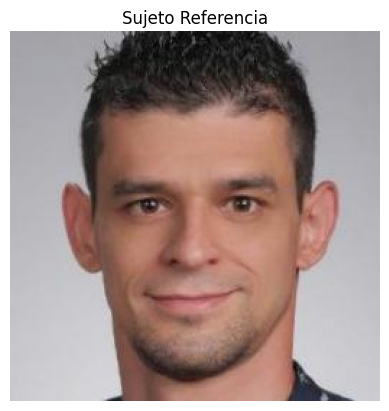

In [19]:
# Imagen de referencia será el sujeto 0
img_reference= "andres.jpg"
img_src = cv2.imread(f"/kaggle/input/images-faceswap/"+img_reference)
img_src_rgb = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
img_src = cv2.resize(img_src_rgb, (256, 256))
img_src = torch.from_numpy(img_src.transpose((2, 0, 1))).float().mul_(1/255.0)
img_src = tF.normalize(img_src, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), False)
img_src = img_src.unsqueeze_(0).cuda()

plt.axis('off')
plt.title("Sujeto Referencia")
plt.imshow(img_src_rgb)
plt.show()

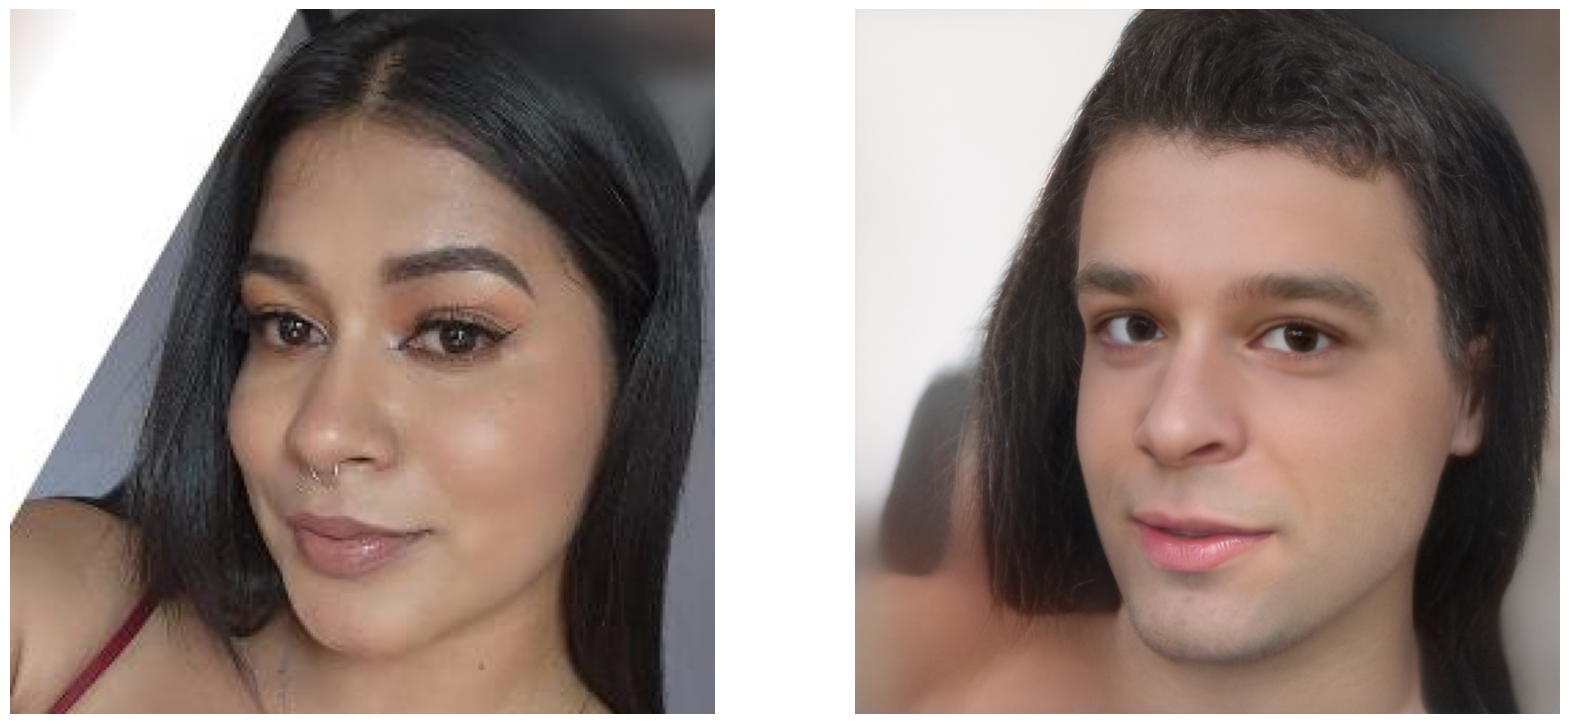

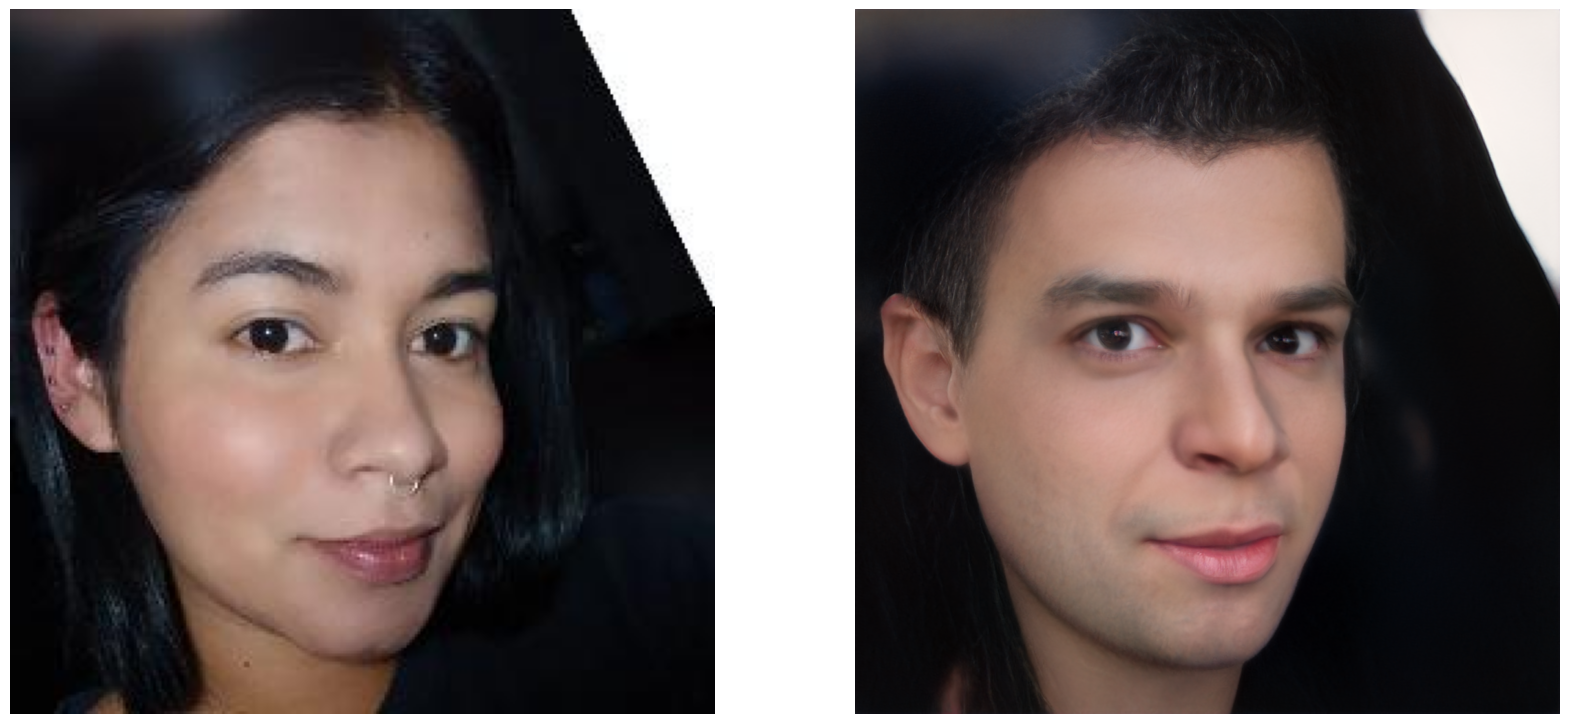

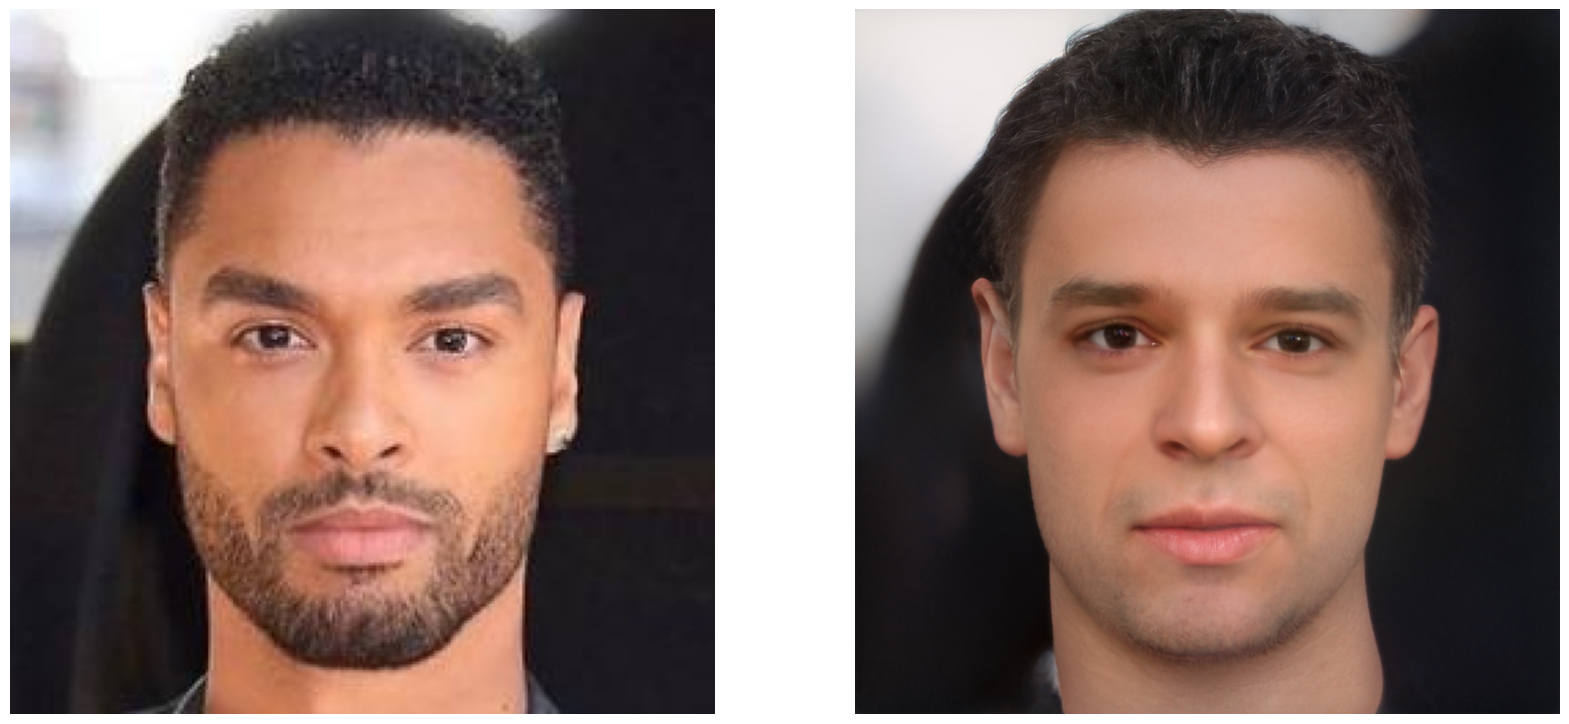

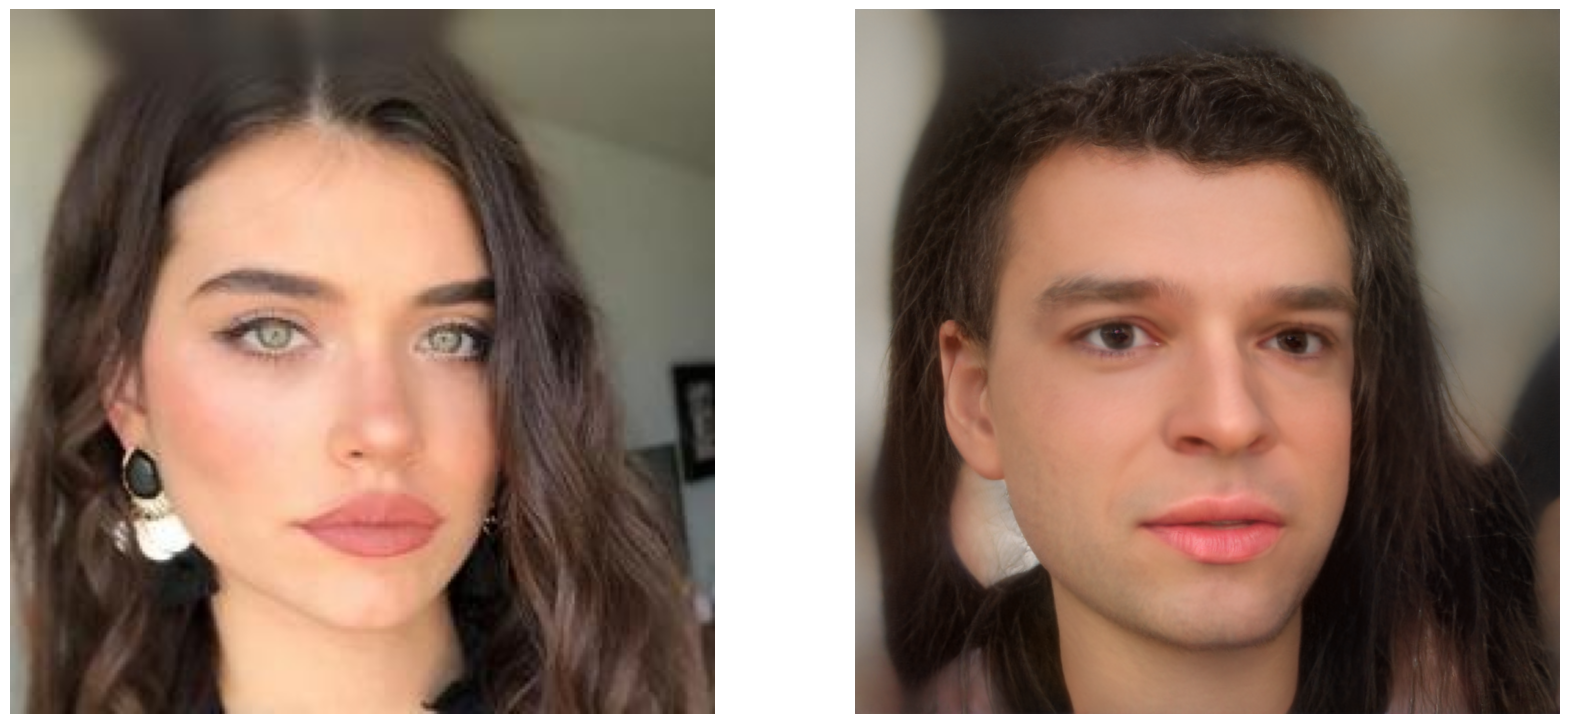

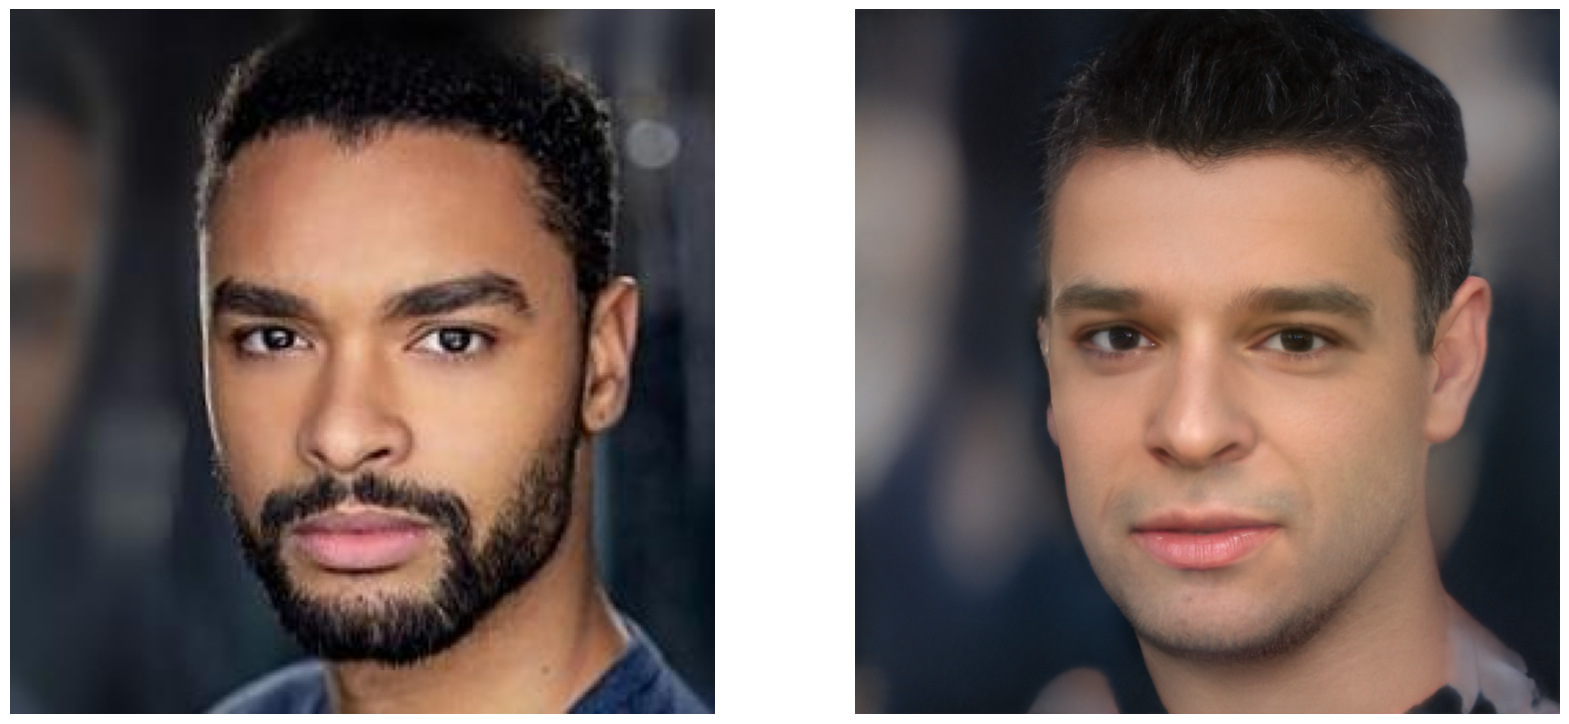

In [18]:
# Ruta de la carpeta con las imágenes
ruta_imagenes = "/kaggle/input/images-faceswap"

# Lista de archivos en la carpeta
archivos = os.listdir(ruta_imagenes)

# Filtra los archivos para excluir "aleja.jpg"
archivos = [archivo for archivo in archivos if archivo != img_reference]

# Para cada archivo
for archivo in archivos:
    # Carga la imagen
    img_path = os.path.join(ruta_imagenes, archivo)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img_rgb, (256, 256))
    img = torch.from_numpy(img.transpose((2, 0, 1))).float().mul_(1/255.0)
    img = tF.normalize(img, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), False)
    img = img.unsqueeze_(0).cuda()

    # Realiza el swapping (asegúrate de tener definidos "encoder", "swapper" y "generator")
    lats_swap, struct_swap = encoder(torch.cat([img, img_src], dim=0).cuda())
    idd_lats = lats_swap[1:]
    att_lats = lats_swap[0].unsqueeze_(0)
    att_struct = struct_swap[0].unsqueeze_(0)
    swapped_lats = swapper(idd_lats, att_lats)
    fake_swap, _ = generator(att_struct, [swapped_lats, None], randomize_noise=False)

    # Normaliza y convierte a numpy
    fake_swap_max = torch.max(fake_swap)
    fake_swap_min = torch.min(fake_swap)
    denormed_fake_swap = (fake_swap[0] - fake_swap_min) / (fake_swap_max - fake_swap_min) * 255.0
    fake_swap_numpy = denormed_fake_swap.permute((1, 2, 0)).cpu().detach().numpy()

    # Muestra las imágenes
    fig = plt.figure(figsize=(20, 10))

    ax2 = fig.add_subplot(1, 2, 1)
    ax2.imshow(img_rgb)
    ax2.axis('off')

    ax3 = fig.add_subplot(1, 2, 2)
    ax3.imshow(fake_swap_numpy/255.0)
    ax3.axis('off')
    plt.show()
